# Pandas Kaggle Tutorial
Dmitry Sergeev, Data Scientist @ ZeptoLab

# [PUBG Finish Placement Prediction](https://www.kaggle.com/c/pubg-finish-placement-prediction)


You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

Data fields
- DBNOs - Number of enemy players knocked.
- assists - Number of enemy players this player damaged that were killed by teammates.
- boosts - Number of boost items used.
- damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
- headshotKills - Number of enemy players killed with headshots.
- heals - Number of healing items used.
- Id - Player’s Id
- killPlace - Ranking in match of number of enemy players killed.
- killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If - - there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- killStreaks - Max number of enemy players killed in a short amount of time.
- kills - Number of enemy players killed.
- longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- matchDuration - Duration of match in seconds.
- matchId - ID to identify match. There are no matches that are in both the training and testing set.
- matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- revives - Number of times this player revived teammates.
- rideDistance - Total distance traveled in vehicles measured in meters.
- roadKills - Number of kills while in a vehicle.
- swimDistance - Total distance traveled by swimming measured in meters.
- teamKills - Number of times this player killed a teammate.
- vehicleDestroys - Number of vehicles destroyed.
- walkDistance - Total distance traveled on foot measured in meters.
- weaponsAcquired - Number of weapons picked up.
- winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- numGroups - Number of groups we have data for in the match.
- maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from tqdm import tqdm_notebook

%matplotlib inline 

/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


## Reading the data

In [2]:
df_train = pd.read_csv('data/train_V2.csv')
df_test  = pd.read_csv('data/test_V2.csv')

In [3]:
df_train.shape, df_test.shape

((4446966, 29), (1934174, 28))

In [4]:
df_train.head().T

,0,1,2,3,4
Id,7f96b2f878858a,eef90569b9d03c,1eaf90ac73de72,4616d365dd2853,315c96c26c9aac
groupId,4d4b580de459be,684d5656442f9e,6a4a42c3245a74,a930a9c79cd721,de04010b3458dd
matchId,a10357fd1a4a91,aeb375fc57110c,110163d8bb94ae,f1f1f4ef412d7e,6dc8ff871e21e6
assists,0,0,1,0,0
boosts,0,0,0,0,0
damageDealt,0,91.47,68,32.9,100
DBNOs,0,0,0,0,0
headshotKills,0,0,0,0,0
heals,0,0,0,0,0
killPlace,60,57,47,75,45


In [5]:
df_train.tail().T

,4446961,4446962,4446963,4446964,4446965
Id,afff7f652dbc10,f4197cf374e6c0,e1948b1295c88a,cc032cdd73b7ac,0d8e7ed728b6fd
groupId,d238e426f50de7,408cdb5c46b2ac,e26ac84bdf7cef,c2223f35411394,8c74f72fedf5ff
matchId,18492834ce5635,ee854b837376d9,6d0cd12784f1ab,c9c701d0ad758a,62a16aabcc095c
assists,0,0,0,0,0
boosts,0,1,0,4,2
damageDealt,0,44.15,59.06,180.4,268
DBNOs,0,0,0,1,0
headshotKills,0,0,0,1,0
heals,0,0,0,2,1
killPlace,74,69,66,11,18


## What if my specs are not that great

<img src="https://assetsds.cdnedge.bluemix.net/sites/default/files/styles/big_2/public/feature/images/potato_pc.jpg?itok=yvuy1BJ3" width="400px" >

- `nrows` - limit the number of rows to read (from the beginning of the file)
- `skiprows` - skip some rows from the beginning of the file
- `chunksize` - allows to iteratively read small chunks of data - very useful
- `dtype` - set types of columns beforehand (more on that later)

In [9]:
pd.read_csv('data/train_V2.csv', chunksize=1000)

In [6]:
df_train_subset = pd.read_csv('data/train_V2.csv', nrows=10000)

In [10]:
df_train_subset.describe(percentiles=[0.1, 0.9]).T

,count,mean,std,min,10%,50%,90%,max
assists,10000.0,0.227900,0.569556,0.0,0.0000,0.0000,1.0000,6.0
boosts,10000.0,1.131500,1.766443,0.0,0.0000,0.0000,4.0000,13.0
damageDealt,10000.0,131.375410,171.317061,0.0,0.0000,81.4350,339.8100,2325.0
DBNOs,10000.0,0.659700,1.140888,0.0,0.0000,0.0000,2.0000,13.0
headshotKills,10000.0,0.226300,0.584228,0.0,0.0000,0.0000,1.0000,8.0
heals,10000.0,1.372000,2.664869,0.0,0.0000,0.0000,5.0000,29.0
killPlace,10000.0,47.746500,27.506826,1.0,10.0000,48.0000,86.0000,100.0
killPoints,10000.0,509.985300,628.937538,0.0,0.0000,0.0000,1387.0000,2026.0
kills,10000.0,0.930200,1.557232,0.0,0.0000,0.0000,3.0000,21.0
killStreaks,10000.0,0.544400,0.718248,0.0,0.0000,0.0000,2.0000,6.0


In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.000000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,84.2400,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,47.0000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.000000,20.0


**Surpressing the scientific notation**

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.000,0.234,0.589,0.000,0.000,0.000,0.000,22.000
boosts,4446966.000,1.107,1.716,0.000,0.000,0.000,2.000,33.000
damageDealt,4446966.000,130.717,170.781,0.000,0.000,84.240,186.000,6616.000
DBNOs,4446966.000,0.658,1.146,0.000,0.000,0.000,1.000,53.000
headshotKills,4446966.000,0.227,0.602,0.000,0.000,0.000,0.000,64.000
heals,4446966.000,1.370,2.680,0.000,0.000,0.000,2.000,80.000
killPlace,4446966.000,47.599,27.463,1.000,24.000,47.000,71.000,101.000
killPoints,4446966.000,505.006,627.505,0.000,0.000,0.000,1172.000,2170.000
kills,4446966.000,0.925,1.558,0.000,0.000,0.000,1.000,72.000
killStreaks,4446966.000,0.544,0.711,0.000,0.000,0.000,1.000,20.000


## Memory optimization

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
dtypes: float64(5), int64(19), object(4)
memory usage: 413.2+ MB


In [15]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in tqdm_notebook(df.columns):
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [16]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 983.90 MB



Memory usage after optimization is: 288.39 MB
Decreased by 70.7%


In [17]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 413.18 MB



Memory usage after optimization is: 121.74 MB
Decreased by 70.5%


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int8
boosts             int8
damageDealt        float16
DBNOs              int8
headshotKills      int8
heals              int8
killPlace          int8
killPoints         int16
kills              int8
killStreaks        int8
longestKill        float16
matchDuration      int16
matchType          object
maxPlace           int8
numGroups          int8
rankPoints         int16
revives            int8
rideDistance       float16
roadKills          int8
swimDistance       float16
teamKills          int8
vehicleDestroys    int8
walkDistance       float16
weaponsAcquired    int16
winPoints          int16
winPlacePerc       float16
dtypes: float16(6), int16(5), int8(14), object(4)
memory usage: 288.4+ MB


## Pandas profiling 

aka _"I'm too lazy to check each column myself"_

https://github.com/pandas-profiling/pandas-profiling

In [19]:
profile = pandas_profiling.ProfileReport(df_train.sample(50000))

In [20]:
profile

Number of variables,30
Number of observations,50000
Total Missing (%),0.0%
Total size in memory,3.6 MiB
Average record size in memory,76.0 B
Numeric,24
Categorical,3
Boolean,0
Date,0
Text (Unique),1
Rejected,2


## Missing values

In [21]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

We have just 1 missing value (out of 4.5 million rows), which is kind of unbelievable. But if we actually had more, we coould use [`missingno` package](https://github.com/ResidentMario/missingno)

In [22]:
import missingno as msno

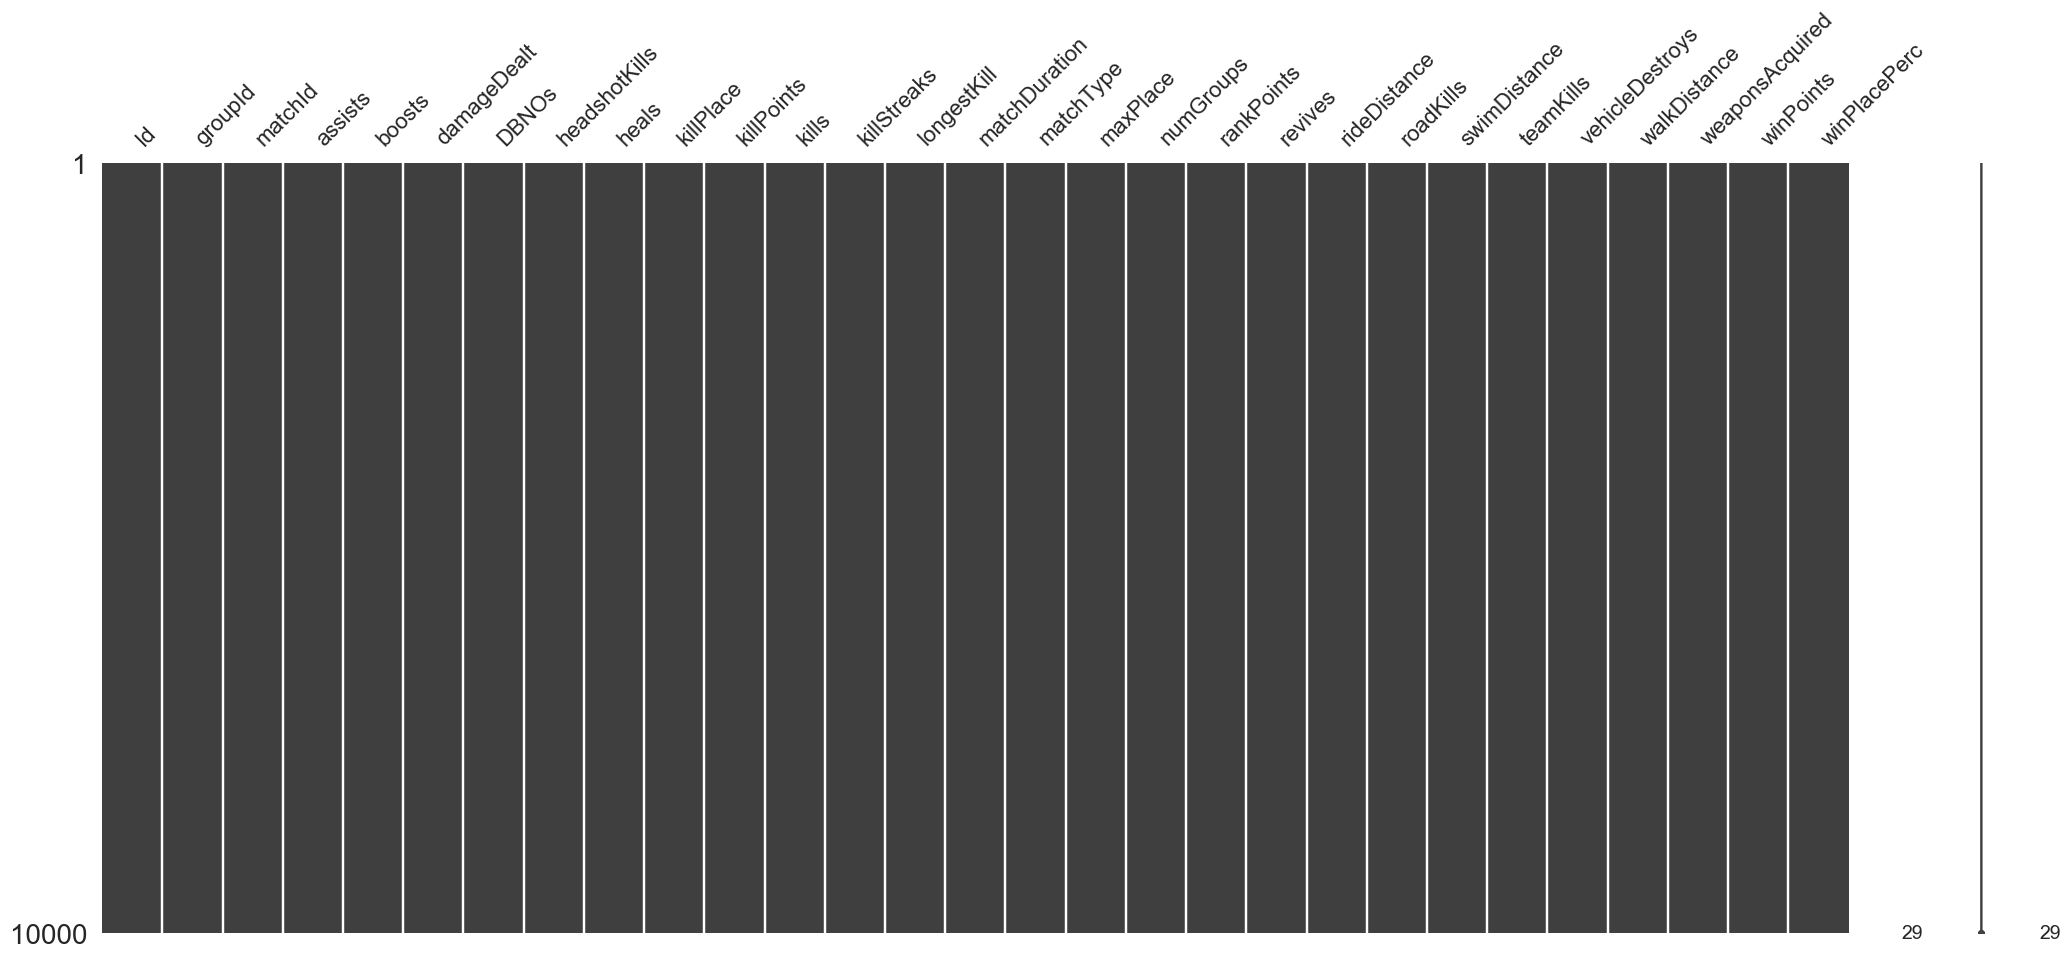

In [23]:
msno.matrix(df_train_subset);

Again, if we had missing values we could

- drop them with `df_train.dropna()`
- fill them with a constant value `.fillna(VALUE)`
- fill them with previous/next not missing values in the dataframe (useful when dealing with timeseries) `.fillna(method='pad')`/`.fillna(method='bfill')`
- interpolate with various methods (only for timeseries) `.interpolate()`
- more sophisticated methods - train models to predict the column with missing values, based on other columns, fill missing with predictions, etc. 

## Working with features

### Divide one by another

In [24]:
headshot = df_train[['kills','winPlacePerc','headshotKills']]
headshot['headshotrate'] = headshot['kills'] / headshot['headshotKills']

In [25]:
headshot.corr()

,kills,winPlacePerc,headshotKills,headshotrate
kills,1.000,0.420,0.674,0.679
winPlacePerc,0.420,1.000,0.278,0.324
headshotKills,0.674,0.278,1.000,-0.083
headshotrate,0.679,0.324,-0.083,1.000


In [26]:
del headshot

In [28]:
df_train['headshotrate'] = df_train['kills']/df_train['headshotKills']
df_test['headshotrate'] = df_test['kills']/df_test['headshotKills']

In [30]:
df_train['headshotrate'] = df_train['headshotrate'].replace(np.inf, 0)
df_train['headshotrate'].fillna(0, inplace=True)

df_test['headshotrate'] = df_test['headshotrate'].replace(np.inf, 0)
df_test['headshotrate'].fillna(0, inplace=True)

### Sum up several features

In [31]:
kills = df_train[['assists','winPlacePerc','kills']]
kills['kills_assists'] = (kills['kills'] + kills['assists'])
kills.corr()

,assists,winPlacePerc,kills,kills_assists
assists,1.000,0.299,0.320,0.593
winPlacePerc,0.299,1.000,0.420,0.453
kills,0.320,0.420,1.000,0.953
kills_assists,0.593,0.453,0.953,1.000


In [32]:
df_train['kills_assists'] = df_train['kills'] + df_train['assists']
df_test['kills_assists'] = df_test['kills'] + df_test['assists']
del kills

### Aggregated features

In [33]:
agg = df_train.groupby(
    ['matchId','groupId']
)[['headshotrate', 'kills_assists']].agg('mean')

In [34]:
agg.head()

headshotrate  kills_assists
matchId        groupId                                    
0000a43bce5eec 18b16ec699d8b6         0.000          1.000
               236ab9e9c081b9         0.000          0.000
               3a6addfa0df938         0.000          0.000
               4bf06994bd4c9a         0.000          0.000
               4d1bbbc19b9084         3.000          4.000

In [35]:
agg_rank = agg.groupby('matchId')[
    ['headshotrate', 'kills_assists']
].rank(pct=True).reset_index()

In [36]:
agg_rank.head()

,matchId,groupId,headshotrate,kills_assists
0,0000a43bce5eec,18b16ec699d8b6,0.339,0.607
1,0000a43bce5eec,236ab9e9c081b9,0.339,0.179
2,0000a43bce5eec,3a6addfa0df938,0.339,0.179
3,0000a43bce5eec,4bf06994bd4c9a,0.339,0.179
4,0000a43bce5eec,4d1bbbc19b9084,0.982,0.893


In [37]:
df_train = pd.merge(
    df_train, 
    agg_rank, 
    suffixes=('', '_aggmean'),
    how='left',
    left_on = ['matchId', 'groupId'],
    right_on=['matchId', 'groupId']
)

In [38]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0,244.750,1,1466,0.444,0.000,0,0.808,0.519
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.500,0,0,0,57,...,0,0,1434.000,5,0,0.640,0.000,0,0.280,0.700
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0,161.750,2,0,0.775,0.000,1,0.372,0.702
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.906,0,0,0,75,...,0,0,202.750,3,0,0.167,0.000,0,0.300,0.200
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0,49.750,2,0,0.188,0.000,1,0.389,0.663


In [39]:
df_train[
    ['headshotrate', 'kills_assists', 
     'headshotrate_aggmean', 'kills_assists_aggmean', 'winPlacePerc']
].corr()

,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean,winPlacePerc
headshotrate,1.000,0.664,0.584,0.430,0.297
kills_assists,0.664,1.000,0.498,0.676,0.453
headshotrate_aggmean,0.584,0.498,1.000,0.648,0.389
kills_assists_aggmean,0.430,0.676,0.648,1.000,0.572
winPlacePerc,0.297,0.453,0.389,0.572,1.000


### Some other stuff

Say we want to select only those rows, where some condition on column values are satisfied

In [40]:
df_train['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

In [41]:
df_train[df_train['matchType']=='duo'].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0,161.750,2,0,0.775,0.000,1,0.372,0.702
23,0b6fbdfb59c994,7a75c3e86934f6,8b0a78c005cea0,0,6,1011.000,6,2,2,2,...,0,0,2728.000,7,1603,0.959,4.500,9,0.978,0.978
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.000,0,0,0,87,...,0,0,0.000,0,0,0.000,0.000,0,0.375,0.170
30,3a4e362d28f411,b4fbf11bf33ac3,cf3d655571b26b,0,0,36.719,0,0,0,62,...,0,0,455.500,5,0,0.426,0.000,0,0.378,0.211
32,e050d1f179d289,9e9fc09bcdab3f,bf3065e01dd3f9,0,3,0.000,0,0,1,61,...,1,0,1240.000,7,0,0.500,0.000,0,0.348,0.185


In [42]:
df_train[
    (df_train['matchType']=='duo')|
    (df_train['matchType']=='solo')
].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0,161.750,2,0,0.775,0.000,1,0.372,0.702
23,0b6fbdfb59c994,7a75c3e86934f6,8b0a78c005cea0,0,6,1011.000,6,2,2,2,...,0,0,2728.000,7,1603,0.959,4.500,9,0.978,0.978
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.000,0,0,0,87,...,0,0,0.000,0,0,0.000,0.000,0,0.375,0.170
30,3a4e362d28f411,b4fbf11bf33ac3,cf3d655571b26b,0,0,36.719,0,0,0,62,...,0,0,455.500,5,0,0.426,0.000,0,0.378,0.211
32,e050d1f179d289,9e9fc09bcdab3f,bf3065e01dd3f9,0,3,0.000,0,0,1,61,...,1,0,1240.000,7,0,0.500,0.000,0,0.348,0.185


In [43]:
df_train[
    df_train['matchType'].isin(['duo', 'solo'])
].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0,161.750,2,0,0.775,0.000,1,0.372,0.702
23,0b6fbdfb59c994,7a75c3e86934f6,8b0a78c005cea0,0,6,1011.000,6,2,2,2,...,0,0,2728.000,7,1603,0.959,4.500,9,0.978,0.978
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.000,0,0,0,87,...,0,0,0.000,0,0,0.000,0.000,0,0.375,0.170
30,3a4e362d28f411,b4fbf11bf33ac3,cf3d655571b26b,0,0,36.719,0,0,0,62,...,0,0,455.500,5,0,0.426,0.000,0,0.378,0.211
32,e050d1f179d289,9e9fc09bcdab3f,bf3065e01dd3f9,0,3,0.000,0,0,1,61,...,1,0,1240.000,7,0,0.500,0.000,0,0.348,0.185


In [44]:
df_train[
    df_train['matchType'].str.contains("solo")
].head()    

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0,49.750,2,0,0.188,0.000,1,0.389,0.663
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539,0,0,0,48,...,0,0,1089.000,6,1500,0.737,0.000,0,0.418,0.283
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,0,1,324.250,0,1,5,5,...,0,0,2050.000,6,1462,0.875,4.000,4,0.979,0.952
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,0,3,254.250,0,0,12,13,...,0,0,1787.000,3,0,0.821,0.000,2,0.468,0.826
35,47143f942503e0,e17a8867a393ec,bc2faecb77e5ec,0,0,136.875,0,0,0,37,...,0,0,270.750,1,0,0.347,0.000,1,0.415,0.654


### Applying transformations

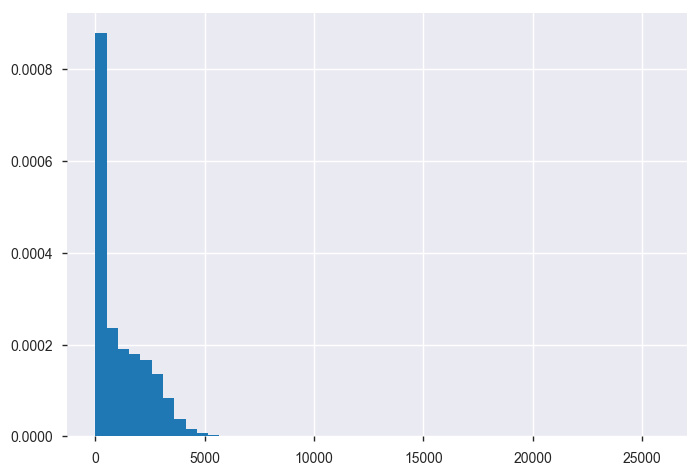

In [45]:
df_train['walkDistance'].hist(bins=50,density=True);

In [46]:
df_train['walkDistance_log'] = df_train['walkDistance'].apply(
    lambda x: np.log(x+1)
)

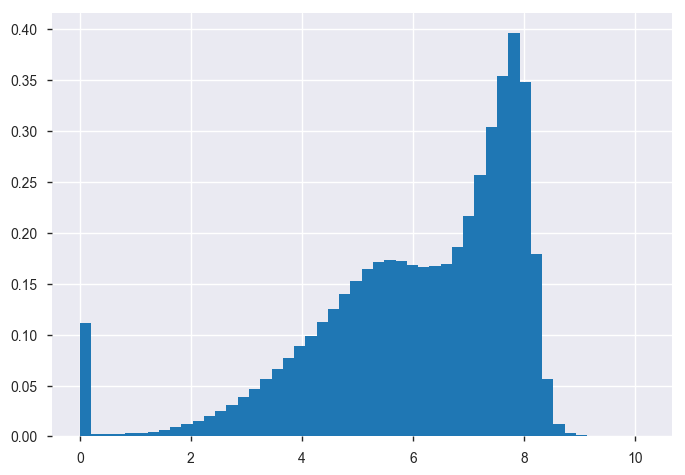

In [47]:
df_train['walkDistance_log'].hist(bins=50,density=True);

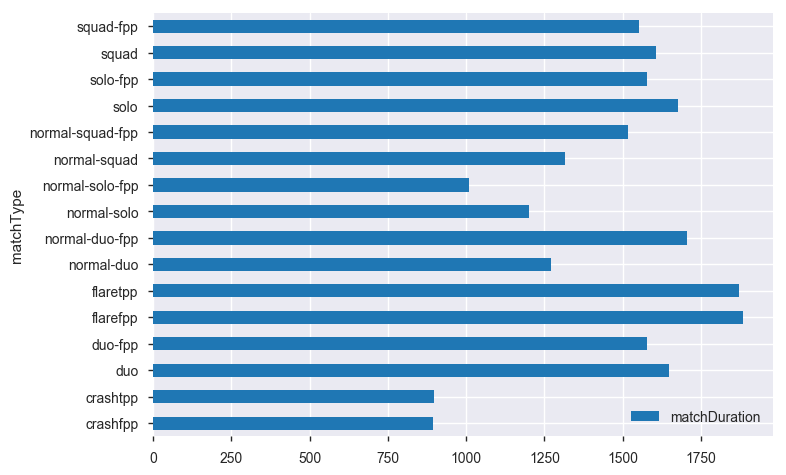

In [48]:
df_train[
    ['matchType','matchDuration']
].groupby('matchType').mean().plot(kind='barh');

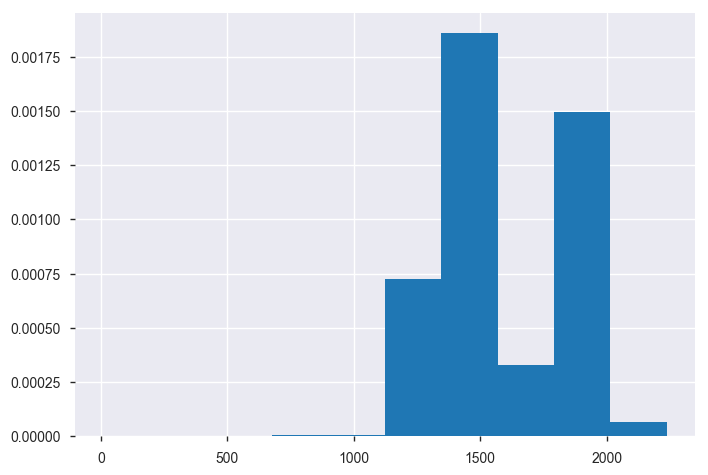

In [49]:
df_train['matchDuration'].hist(density=True);

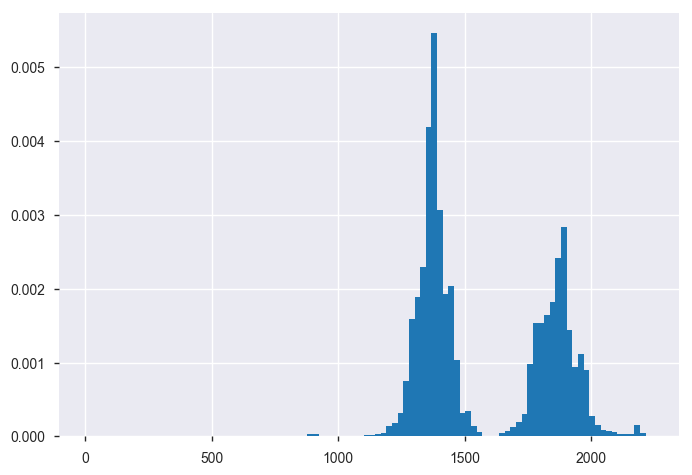

In [50]:
df_train['matchDuration'].hist(bins=100, density=True);

In [51]:
df_train.corr()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,headshotrate,kills_assists,headshotrate_aggmean,kills_assists_aggmean,walkDistance_log
assists,1.000,0.308,0.407,0.301,0.198,0.229,-0.290,0.039,0.320,0.243,...,0.058,0.290,0.244,0.024,0.299,0.221,0.593,0.283,0.440,0.236
boosts,0.308,1.000,0.522,0.359,0.335,0.536,-0.555,0.008,0.502,0.405,...,0.087,0.640,0.407,-0.008,0.634,0.367,0.525,0.359,0.494,0.520
damageDealt,0.407,0.522,1.000,0.736,0.613,0.343,-0.677,0.050,0.889,0.704,...,0.081,0.398,0.353,0.018,0.441,0.623,0.886,0.456,0.603,0.363
DBNOs,0.301,0.359,0.736,1.000,0.470,0.265,-0.555,0.043,0.708,0.647,...,0.060,0.285,0.218,0.011,0.280,0.501,0.698,0.353,0.441,0.267
headshotKills,0.198,0.335,0.613,0.470,1.000,0.200,-0.470,0.024,0.674,0.513,...,0.039,0.251,0.218,0.005,0.278,0.655,0.637,0.540,0.406,0.218
heals,0.229,0.536,0.343,0.265,0.200,1.000,-0.386,-0.003,0.312,0.270,...,0.063,0.430,0.309,-0.011,0.428,0.224,0.338,0.246,0.345,0.374
killPlace,-0.290,-0.555,-0.677,-0.555,-0.470,-0.386,1.000,-0.023,-0.730,-0.811,...,-0.074,-0.590,-0.490,-0.002,-0.719,-0.489,-0.714,-0.497,-0.746,-0.638
killPoints,0.039,0.008,0.050,0.043,0.024,-0.003,-0.023,1.000,0.036,0.037,...,-0.010,0.005,-0.004,0.983,0.013,0.027,0.043,0.023,0.028,0.007
kills,0.320,0.502,0.889,0.708,0.674,0.312,-0.730,0.036,1.000,0.803,...,0.080,0.375,0.336,0.007,0.420,0.698,0.953,0.479,0.629,0.332
killStreaks,0.243,0.405,0.704,0.647,0.513,0.270,-0.811,0.037,0.803,1.000,...,0.064,0.328,0.275,0.009,0.378,0.529,0.760,0.436,0.646,0.334


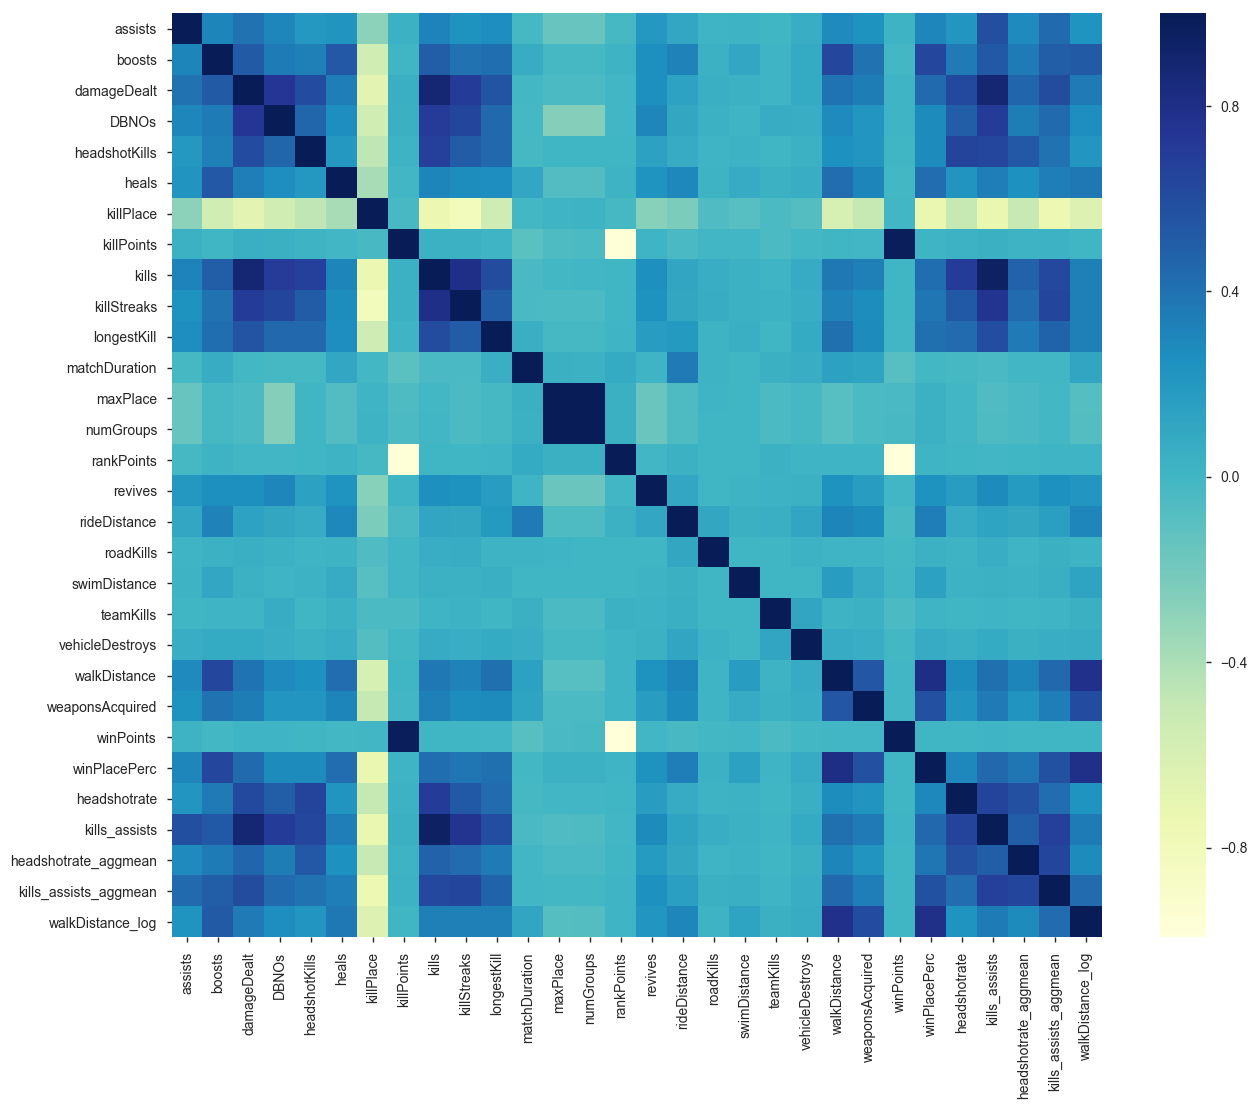

In [52]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_train.corr(), cmap="YlGnBu");

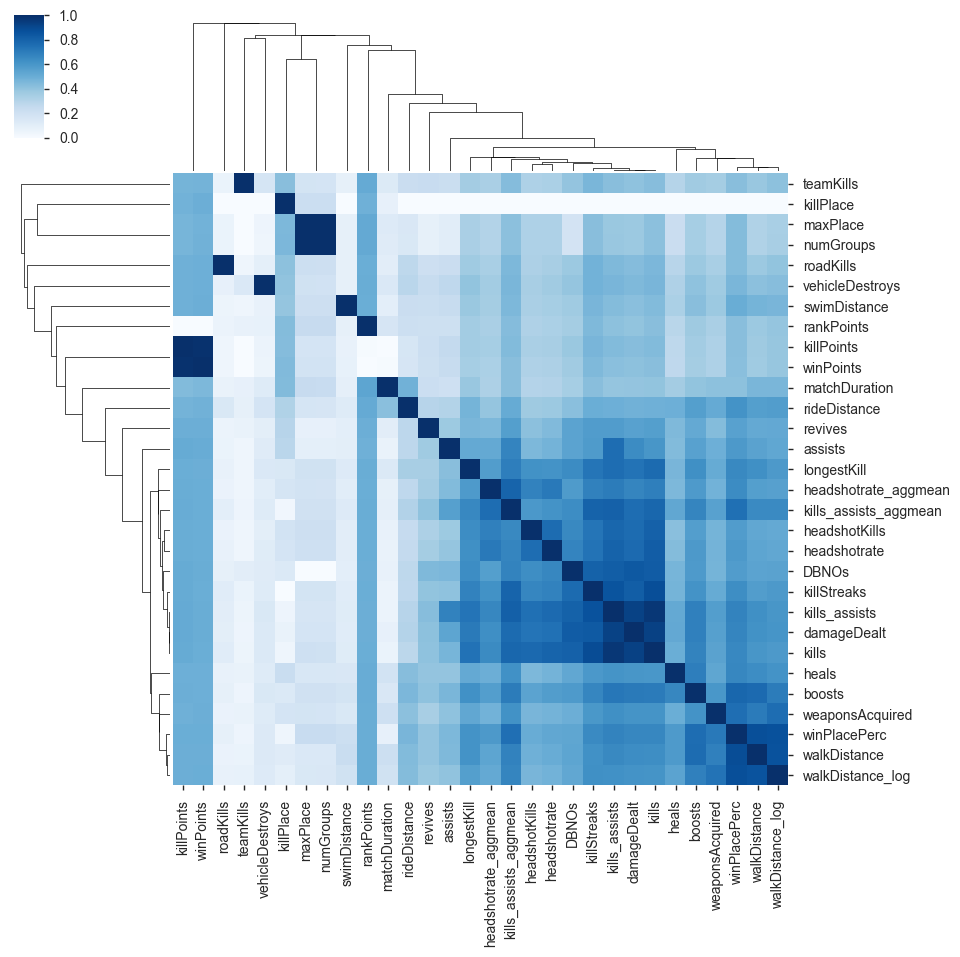

In [53]:
sns.clustermap(
    df_train.corr(), metric="correlation", 
    method="single", cmap="Blues", standard_scale=1);